In [109]:
# import
import numpy as np
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm
from sklearn.model_selection import train_test_split
import scipy.io
import utils.starplus_utils as starp
from numpy.linalg import norm
from tensor.utils import assert_compatile_sizes_modek, reshape, make_axis_iterable
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib.cm import ScalarMappable
from numpy.linalg import svd
from tensor.mode_k import modek_unfold
from sklearn.utils.extmath import randomized_svd
from scipy.stats import ortho_group
from tensor.M_Matrix import banded_matrix, haar_normalized, random_ortho, data_dependent_matrix

In [110]:
# ==================================================================================================================== #
# for reproducibility
np.random.seed(20)

In [111]:
# load data
# we need the variables
#   training_data, training_labels, test_data, test_labels, num_classes
num_classes = 2
star_plus_data_1 = scipy.io.loadmat('data-starplus-04799-v7.mat')
star_plus_data_2 = scipy.io.loadmat('data-starplus-04820-v7.mat')
star_plus_data_3 = scipy.io.loadmat('data-starplus-04847-v7.mat')
star_plus_data_4 = scipy.io.loadmat('data-starplus-05675-v7.mat')
star_plus_data_5 = scipy.io.loadmat('data-starplus-05680-v7.mat')
star_plus_data_6 = scipy.io.loadmat('data-starplus-05710-v7.mat')
tensor_PS_1, labels_1 = starp.get_labels(star_plus_data_1)
tensor_PS_2, labels_2 = starp.get_labels(star_plus_data_2)
tensor_PS_3, labels_3 = starp.get_labels(star_plus_data_3)
tensor_PS_4, labels_4 = starp.get_labels(star_plus_data_4)
tensor_PS_5, labels_5 = starp.get_labels(star_plus_data_5)
tensor_PS_6, labels_6 = starp.get_labels(star_plus_data_6)
labels = np.concatenate((labels_1,labels_2,labels_3,labels_4,labels_5,labels_6), axis = None)
tensor_PS = np.concatenate((tensor_PS_1, tensor_PS_2, tensor_PS_3, tensor_PS_4, tensor_PS_5, tensor_PS_6), axis=4)
tensor_PS  = tensor_PS / norm(tensor_PS)

In [112]:
labels = labels.reshape((1,480))
print(labels)
print(labels.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 

In [113]:
print(np.transpose(labels).shape)
print(np.moveaxis(tensor_PS, -1, 0).shape)
training_data, test_data, training_labels, test_labels = train_test_split(np.moveaxis(tensor_PS, -1, 0), np.transpose(labels), test_size=0.33, random_state=42)
print(training_data.shape)
(unique, counts) = np.unique(test_labels, return_counts=True)
print(unique)
print(counts)
(unique, counts) = np.unique(training_labels, return_counts=True)
print(unique)
print(counts)

(480, 1)
(480, 64, 64, 8, 16)
(321, 64, 64, 8, 16)
[0. 1.]
[81 78]
[0. 1.]
[159 162]


In [114]:
# ==================================================================================================================== #
# choose product type {'f', 't', 'c'，'m','minv'}
# m-product using haarMatrix
prod_type = 'm'
# choose Matrix type {'haar as h', 'random_ortho as ro','data_dependent_matrix as ddm'}
m_type = 'ddm'

In [115]:
# ==================================================================================================================== #
# define projection
def projection(A, U, prod_type):
    if prod_type == 'minv':
        # Banded Matrix
        training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type,M = (banded_matrix(64,8),banded_matrix(8,2),banded_matrix(16,3)))
        return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (banded_matrix(64,8),banded_matrix(8,2),banded_matrix(16,3)))
    elif prod_type == 'm':
        if m_type == 'h':
            training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
            return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
        elif m_type == 'ddm':
            training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type, M = data_dependent_matrix(training_data))
            return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = data_dependent_matrix(training_data))
        elif m_type == 'ro':
            training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type,M = (random_ortho(64),random_ortho(8),random_ortho(16)))
            return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (random_ortho(64),random_ortho(8),random_ortho(16)))
    else:
        training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type)
        return tp.ten_prod(U, training_coeff, prod_type=prod_type) 

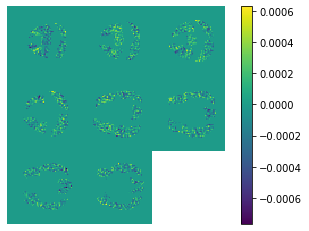

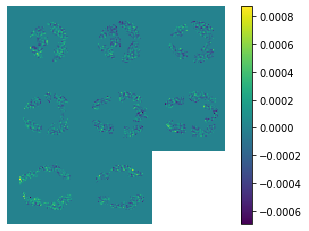

In [116]:
# visualize data
# use the existing tools or write your own!
plt.figure(1)
montage_array(training_data[0, :, :, :, 0], cmap='viridis')
plt.show()
plt.figure(2)
montage_array(test_data[0, :, :, :, 0], cmap='viridis')
plt.show()

In [117]:
# move the label number to second axis
training_data = np.moveaxis(training_data, 0, 1)
test_data = np.moveaxis(test_data, 0, 1)
print(training_data.shape)
print(test_data.shape)

(64, 321, 64, 8, 16)
(64, 159, 64, 8, 16)


In [118]:
# create the boolean array for training and testing
boolean_list = []
for i in (training_labels):
    boolean_list.append(i[0])
boolean_array_training = np.asarray(boolean_list)
print(boolean_array_training)

boolean_list = []
for i in (test_labels):
    boolean_list.append(i[0])
boolean_array_testing = np.asarray(boolean_list)
print(boolean_array_testing)

[0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 1. 0. 0. 

In [122]:
# ==================================================================================================================== #
# form local t-svd
# num_class should be 2
num_classes = len(np.unique(training_labels))
k = 8

U = []
print(num_classes)

for i in range(num_classes):
    if prod_type == 'minv':
        u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = (banded_matrix(64,8),banded_matrix(8,2),banded_matrix(16,3)))
        U.append(u)
    elif prod_type == 'm':
        if m_type == 'h':
            u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
        elif m_type == 'ddm':
            u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = data_dependent_matrix(training_data))
        elif m_type == 'ro':
            u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = (ortho_group.rvs(64),ortho_group.rvs(8),ortho_group.rvs(16)))
        U.append(u)
    else:
        u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type)
        U.append(u)

2


(64, 8, 64)


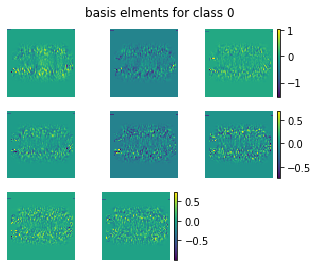

(64, 8, 64)


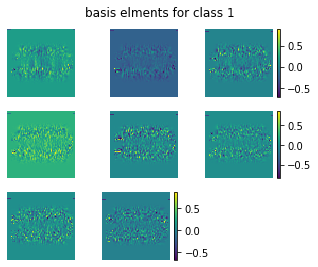

In [123]:
# visualizations
# use the existing tools or write your own!
for i in range(num_classes):
    print(U[i][:, :, :, 0, 0].shape)
    slice_subplots(U[i][:, :, :, 0, 0], axis=1, title='basis elments for class ' + str(i))
    plt.show()

train accuracy = 100.00
test accuracy = 67.30


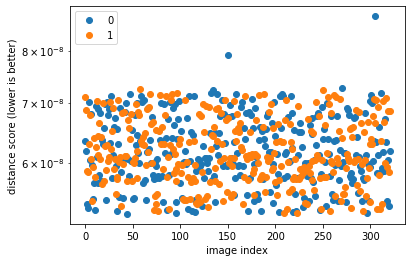

In [124]:
# ==================================================================================================================== #
# compute results on training and test data
training_error = np.zeros([num_classes, training_data.shape[1]])
test_error = np.zeros([num_classes, test_data.shape[1]])
for i in range(num_classes):
    training_projection = projection(training_data, U[i], prod_type=prod_type)
    training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

    test_projection = projection(test_data, U[i], prod_type=prod_type)
    test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


# classification
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

# results

training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
test_accuracy = test_num_correct / test_data.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# plot results
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

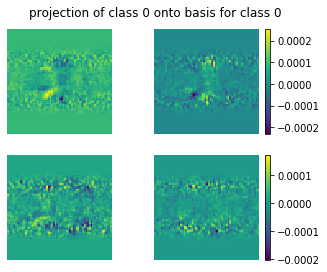

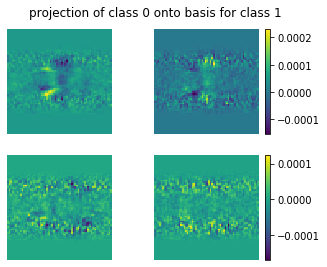

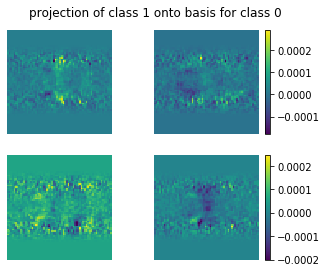

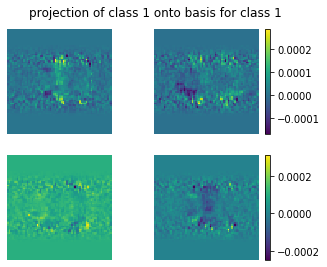

In [95]:
# ==================================================================================================================== #
# visualizations of projected tensors
# use the existing tools or write your own!

for j in range(num_classes):
    for i in range(num_classes):
        A = projection(training_data[:,boolean_array_training == j,:], U[i], prod_type=prod_type)
        slice_subplots(A[:, :4, :,0,0], axis=1, title='projection of class ' + str(j) + ' onto basis for class ' + str(i))
        plt.show()